# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  1
 -1

### We create a function to visualize the data

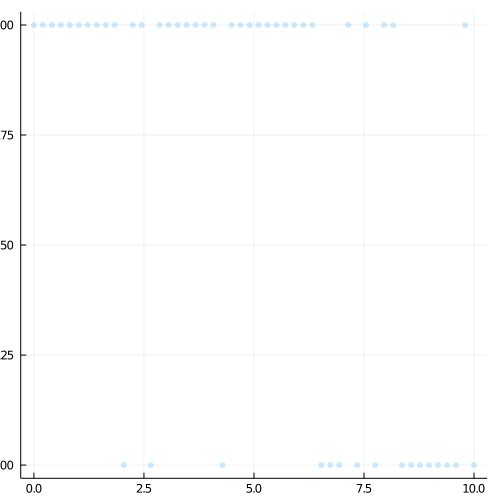

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.985628 seconds (1.87 M allocations: 106.802 MiB, 99.52% compilation time)


(Variational Gaussian Process with a Bernoulli Likelihood with Logistic Link infered by Analytic Variational Inference , (local_vars = (c = [1.4447379305783046, 1.5407528158239103, 1.6156376081947101, 1.6586121139323702, 1.6633316342623095, 1.6291853318442522, 1.5616085191923181, 1.4712761365937772, 1.372203668285644, 1.2790425729198305  …  0.802658039300329, 0.8922735452906266, 0.9892245003455064, 1.0778621441313505, 1.1426260734988103, 1.172977471361985, 1.1663882868813282, 1.128976460413442, 1.0737264018572286, 1.0170827806030687], θ = [0.21400924591917878, 0.21001041342686802, 0.20684875244427386, 0.20502177996973653, 0.20482068728688474, 0.20627365117551047, 0.20913310848933137, 0.21291127289417888, 0.21697650494838008, 0.22070161154657192  …  0.2373897287244781, 0.23463558982382748, 0.23142847691021914, 0.22831231447208777, 0.22593696129143906, 0.22479782635695691, 0.2250464654178991, 0.22644401189424762, 0.22846129875167914, 0.23046695469616332]), opt_state = (NamedTuple(),), hy

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:35
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:50
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:53
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:25
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:07
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:56
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:48
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:42
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.7525767617807854, 1.2640050691560398, 1.74331876801451, 2.070235268634205, 2.2206186763624642, 2.2370247459464125, 2.163264403286366, 2.0561651321261403, 1.9474080363923347, 1.8947045828054527  …  -0.3808635219739378, -0.46483786429695373, -0.5653061860174532, -0.7078662545538619, -0.8301866335112238, -0.9631732744186345, -1.1535735167354573, -1.3112921748142854, -1.486462861874255, -1.630767140757912]]
 [[-0.2103580498714508, 0.02408166452281635, 0.26100507096526226, 0.4868842342440627, 0.7118833279895835, 0.9892543015273989, 1.1903425267951202, 1.3377321731626548, 1.4307400789527023, 1.4362655813819072  …  -0.2883731896520932, -0.6392672196559529, -0.9286026699784125, -1.1384928149893823, -1.187775112572593, -1.0564936237248985, -0.7223502819105987, -0.27631725630424386, 0.27594382956651786, 0.8225136804807432]]
 [[1.6304862066187484, 1.9486672738080726, 2.150573527398517, 2.2230653862145653, 2.236939450316225, 2.150884959068116, 1.9

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

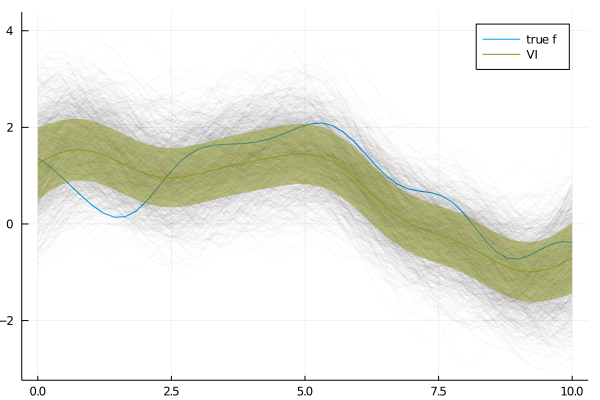

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

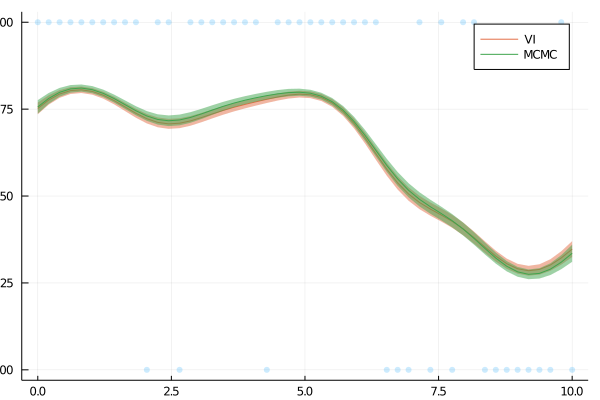

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*